<a href="https://colab.research.google.com/github/anaC-Fernandes/ProjetoDados/blob/main/Notebooks/Dataset_Crise.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### **Tema:** 📉 Crise
### **Pergunta:** A partir da análise do PIB, quais regiões se recuperaram da recessão de 2014-2016?



## **Manipulação Inicial do dados sobre Crise**

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

## **Tabela BrStats**

Lendo o arquivo **BrStats** e definindo ';' como separador.

In [ ]:
dados = pd.read_csv('https://raw.githubusercontent.com/anaC-Fernandes/ProjetoDados/refs/heads/main/Datasets/BrStats.csv', sep = ';', low_memory= False)
dados

,Ano,CDMunicipio,Populacao,PessoalOcupado,PessoalAssalariado,VrSalarios,PIB,QtEmpresas,AreaPlantada_h,AreaColhida_h,...,Exportacoes_US$,Receitas_R$,Transferencias_correntes_R$,Transferencias_capital_R$,NrNascimentos,NrObitosInfantis,povoamento,UF,Municipio,Regiao
0,2016,3509452,5.932,854,537,13.692,111.190,252.0,38.0,38.0,...,NaN,"25.511.889,220","18.911.068,400","1.665.392,540",80.0,0.0,"32,065",SP,Campina do Monte Alegre,Sudeste
1,2016,3123601,27.505,5.680,4.778,104.977,554.663,671.0,3.0,3.0,...,"1.777.256,000","63.002.672,933","45.304.154,440","538.882,600",299.0,3.0,"55,065",MG,Elói Mendes,Sudeste
2,2016,3552007,6.193,668,580,12.519,62.441,83.0,0.0,0.0,...,NaN,"30.492.825,449","21.861.157,950","1.048.458,040",59.0,2.0,"14,930",SP,Silveiras,Sudeste
3,2016,3305604,21.279,3.087,2.669,80.161,403.121,290.0,0.0,0.0,...,NaN,"140.538.926,872","100.508.822,360","871.234,340",272.0,2.0,"22,698",RJ,Silva Jardim,Sudeste
4,2016,1717008,4.534,212,183,5.309,48.551,34.0,94.0,34.0,...,NaN,"15.541.375,953","13.178.989,760","8.037,870",43.0,1.0,"2,908",TO,Pindorama do Tocantins,Norte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33415,2021,2705408,7.171,463,436,10.502,NaN,32.0,0.0,0.0,...,NaN,NaN,NaN,NaN,135.0,3.0,"83,287",AL,Monteirópolis,Nordeste
33416,2021,1600105,9.265,428,383,9.932,NaN,38.0,0.0,0.0,...,NaN,NaN,NaN,NaN,160.0,2.0,"1,010",AP,Amapá,Norte
33417,2019,2605459,3.061,2.210,1.773,43.093,192.775,289.0,0.0,0.0,...,NaN,NaN,NaN,NaN,32.0,1.0,"180,059",PE,Fernando de Noronha,Nordeste
33418,2020,1503002,7.070,538,514,12.207,63.579,32.0,0.0,0.0,...,NaN,NaN,NaN,NaN,149.0,4.0,"0,601",PA,Faro,Norte


### Tabela BrStats contendo apenas 'UF', 'Municipio', 'Regiao'e 'PIB'

Para responder a pergunta **9. A partir da análise do PIB, quais municípios se recuperaram da recessão de 2014-2016?** precisaremos apenas dos seguintes dados:
- UF
- Municipio
- Regiao
- PIB
- Ano

Por esse motivo fizemos uma filtragem na tabela BrStats, retirando os dados não necessãrios para essa pergunta.

In [61]:
dados_filtrados = dados[['UF', 'Municipio', 'Regiao', 'PIB', 'Ano']]

dados_filtrados

,UF,Municipio,Regiao,PIB,Ano
0,SP,Campina do Monte Alegre,Sudeste,111.190,2016
1,MG,Elói Mendes,Sudeste,554.663,2016
2,SP,Silveiras,Sudeste,62.441,2016
3,RJ,Silva Jardim,Sudeste,403.121,2016
4,TO,Pindorama do Tocantins,Norte,48.551,2016
...,...,...,...,...,...
33415,AL,Monteirópolis,Nordeste,NaN,2021
33416,AP,Amapá,Norte,NaN,2021
33417,PE,Fernando de Noronha,Nordeste,192.775,2019
33418,PA,Faro,Norte,63.579,2020


É possível salvar a nova tabela em um arquivo .csv separado:

In [62]:
dados_filtrados.to_csv("BrStats_crise.csv", index=False)

## **Tabela sidra**

Como mencionado no README, fizemos uma busca no Sidra para encontrar dados do PIB dos municípios brasileiros dos anos de 2013 (anterior a crise) até 2016 (fim da crise), o arquivo gerado é o sidra.csv.

Abaixo estamos carregando e manipulando o arquivo sidra, para que possamos unir as duas tabelas de dados.

In [64]:
# Carregando o arquivo CSV com a codificação correta UTF-8, pois estava perdendo acentos
dados_sidra = pd.read_csv('https://raw.githubusercontent.com/anaC-Fernandes/ProjetoDados/refs/heads/main/Datasets/sidra.csv', skiprows=1, encoding='utf-8')

# Renomeando as colunas
dados_sidra.columns = ['Município', '2013', '2014', '2015', '2016', '2017']

# Removendo linhas sem dados úteis que vieram do PDF (Fonte, Notas, etc.)
dados_sidra = dados_sidra.dropna() 
dados_sidra = dados_sidra[~dados_sidra['Município'].str.contains('Fonte:|Notas|1 -', na=False)] 

# Salvando o arquivo corrigido com codificação UTF-8
dados_sidra.to_csv('sidra_limpos.csv', index=False, encoding='utf-8-sig')

Um detalhe a ser corrigido antes de unirmos as tabelas do BrStats com a do Sidra é a maneira como municípios e UF estão registrados, enquanto o dataset BrStats possui uma coluna chamada 'UF', o dataset do Sidra escreve a UF na mesma coluna do município, e por isso devemos criar uma nova coluna nesse dataset.

In [65]:
# Criando a coluna UF
if 'UF' not in dados_sidra.columns:
    dados_sidra['UF'] = ''

# Separaando Município e UF
dados_sidra[['Município', 'UF']] = dados_sidra['Município'].str.extract(r'(.+) \((\w{2})\)')

dados_sidra

,Município,2013,2014,2015,2016,2017,UF
0,Alta Floresta D'Oeste,341.325,377.799,421.300,478.217,485.374,RO
1,Ariquemes,1.799.853,1.921.532,2.037.799,2.184.346,2.287.910,RO
2,Cabixi,96.365,113.477,116.565,133.342,138.110,RO
3,Cacoal,1.433.254,1.660.650,1.794.478,1.947.283,2.082.761,RO
4,Cerejeiras,353.270,392.417,397.736,408.194,439.245,RO
...,...,...,...,...,...,...,...
5565,Vianópolis,291.919,302.880,312.348,373.802,395.861,GO
5566,Vicentinópolis,259.422,275.800,322.298,351.750,350.839,GO
5567,Vila Boa,103.233,90.478,111.229,138.810,118.639,GO
5568,Vila Propício,142.970,138.474,198.935,210.475,182.203,GO


## **Unindo os dois Datasets**

O dataset BrStats não possui colunas específicas para os anos em que os PIBs foram registrados, então optamos por fazer divisão para facilitar a análise.

In [66]:
# Criando um DataFrame onde cada ano vira uma coluna
dados = dados.pivot_table(
    index=['UF', 'Municipio', 'Regiao'],  # Colunas que permanecerão como índice
    columns='Ano',                        # Coluna que será transformada em novas colunas
    values='PIB',                         # Valores que preencherão as novas colunas
    aggfunc='first'                       # Função de agregação (usamos 'first' pois não há duplicatas)
)

# Resetar o índice para trazer UF, Municipio e Regiao de volta como colunas
dados = dados.reset_index()

dados

Ano,UF,Municipio,Regiao,2016,2017,2018,2019,2020
0,AC,Acrelândia,Norte,239.610,229.644,253.138,253.152,302.445
1,AC,Assis Brasil,Norte,85.322,91.743,89.875,92.705,96.920
2,AC,Brasiléia,Norte,388.521,388.018,439.547,454.009,480.142
3,AC,Bujari,Norte,159.696,158.301,158.191,159.100,183.818
4,AC,Capixaba,Norte,177.480,170.990,164.238,152.806,145.318
...,...,...,...,...,...,...,...,...
5560,TO,Tocantínia,Norte,61.070,67.831,71.807,129.131,135.159
5561,TO,Tupirama,Norte,46.019,46.142,49.166,55.980,94.549
5562,TO,Tupiratins,Norte,28.051,28.582,29.772,29.993,33.798
5563,TO,Wanderlândia,Norte,154.098,161.897,140.641,134.885,149.907


Outro problema a ser corrigido é a coluna 'Municipio' no dataset do Sidra, que possui acentuação, enquanto a do BrStats não possui, e precisaremos que elas possuam nomeclatura idêntica para uni-las.

In [67]:
dados_sidra = dados_sidra.rename(columns={'Município': 'Municipio'})

Unindo os dois datasets utilizando como base as colunas 'Municipio' e 'UF'.

In [68]:
dados_crise = dados.merge(dados_sidra, on=['Municipio', 'UF'])

# Salvar o arquivo corrigido com codificação UTF-8
dados_crise.to_csv('dados_crise.csv', index=False, encoding='utf-8-sig')

dados_crise

,UF,Municipio,Regiao,2016,2017,2018,2019,2020,2013,2014,2015,2016,2017
0,AC,Acrelândia,Norte,239.610,229.644,253.138,253.152,302.445,214.652,207.822,212.961,239.610,229.644
1,AC,Assis Brasil,Norte,85.322,91.743,89.875,92.705,96.920,64.602,73.332,77.234,85.322,91.743
2,AC,Brasiléia,Norte,388.521,388.018,439.547,454.009,480.142,294.874,340.917,388.114,388.521,388.018
3,AC,Bujari,Norte,159.696,158.301,158.191,159.100,183.818,120.210,129.895,147.868,159.696,158.301
4,AC,Capixaba,Norte,177.480,170.990,164.238,152.806,145.318,158.800,149.067,160.134,177.480,170.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5444,TO,Tocantínia,Norte,61.070,67.831,71.807,129.131,135.159,47.927,49.172,58.998,61.070,67.831
5445,TO,Tupirama,Norte,46.019,46.142,49.166,55.980,94.549,79.472,68.282,47.485,46.019,46.142
5446,TO,Tupiratins,Norte,28.051,28.582,29.772,29.993,33.798,21.891,25.998,24.533,28.051,28.582
5447,TO,Wanderlândia,Norte,154.098,161.897,140.641,134.885,149.907,125.772,134.428,138.573,154.098,161.897


É possível perceber que o dataset ainda precisa de alguns ajustes, como ordenar corretamente os anos e remover os que se repetem.

In [69]:
dados_crise = pd.read_csv('dados_crise.csv')
dados_crise

,UF,Municipio,Regiao,2016,2017,2018,2019,2020,2013,2014,2015,2016.1,2017.1
0,AC,Acrelândia,Norte,239.610,229.644,253.138,253.152,302.445,214.652,207.822,212.961,239.610,229.644
1,AC,Assis Brasil,Norte,85.322,91.743,89.875,92.705,96.920,64.602,73.332,77.234,85.322,91.743
2,AC,Brasiléia,Norte,388.521,388.018,439.547,454.009,480.142,294.874,340.917,388.114,388.521,388.018
3,AC,Bujari,Norte,159.696,158.301,158.191,159.100,183.818,120.210,129.895,147.868,159.696,158.301
4,AC,Capixaba,Norte,177.480,170.990,164.238,152.806,145.318,158.800,149.067,160.134,177.480,170.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5444,TO,Tocantínia,Norte,61.070,67.831,71.807,129.131,135.159,47.927,49.172,58.998,61.070,67.831
5445,TO,Tupirama,Norte,46.019,46.142,49.166,55.980,94.549,79.472,68.282,47.485,46.019,46.142
5446,TO,Tupiratins,Norte,28.051,28.582,29.772,29.993,33.798,21.891,25.998,24.533,28.051,28.582
5447,TO,Wanderlândia,Norte,154.098,161.897,140.641,134.885,149.907,125.772,134.428,138.573,154.098,161.897


In [70]:
# Removendo colunas duplicadas
cols_to_remove = ['2016.1', '2017.1']
dados_crise = dados_crise.drop(columns=[col for col in cols_to_remove if col in dados_crise.columns])

# Reordenando colunas
fixed_cols = ['UF', 'Municipio', 'Regiao']
year_cols = sorted([col for col in dados_crise.columns if col.isdigit()])
dados_crise = dados_crise[fixed_cols + year_cols]

# Salvando o resultado
output_file = '.dados_final.csv'
dados_crise.to_csv(output_file, index=False)

dados_crise

,UF,Municipio,Regiao,2013,2014,2015,2016,2017,2018,2019,2020
0,AC,Acrelândia,Norte,214.652,207.822,212.961,239.610,229.644,253.138,253.152,302.445
1,AC,Assis Brasil,Norte,64.602,73.332,77.234,85.322,91.743,89.875,92.705,96.920
2,AC,Brasiléia,Norte,294.874,340.917,388.114,388.521,388.018,439.547,454.009,480.142
3,AC,Bujari,Norte,120.210,129.895,147.868,159.696,158.301,158.191,159.100,183.818
4,AC,Capixaba,Norte,158.800,149.067,160.134,177.480,170.990,164.238,152.806,145.318
...,...,...,...,...,...,...,...,...,...,...,...
5444,TO,Tocantínia,Norte,47.927,49.172,58.998,61.070,67.831,71.807,129.131,135.159
5445,TO,Tupirama,Norte,79.472,68.282,47.485,46.019,46.142,49.166,55.980,94.549
5446,TO,Tupiratins,Norte,21.891,25.998,24.533,28.051,28.582,29.772,29.993,33.798
5447,TO,Wanderlândia,Norte,125.772,134.428,138.573,154.098,161.897,140.641,134.885,149.907


Com isso obtivemos um dataset com apenas os dados necessários para a análise do PIB antes, durante e depois da crise de 2014-2016.

## **Conversão dos dados para os tipos corretos**

In [71]:
# Converte as colunas de PIB para float (tratando vírgulas e valores inválidos, se necessário)
for col in year_cols:
    dados_crise[col] = (
        dados_crise[col]
        .str.replace('.', '', regex=False)  # Remove separador de milhar
        .str.replace(',', '.', regex=False)  # Converte vírgula decimal para ponto
        .astype(float)  # Converte para float
    )

dados_crise[['UF', 'Municipio', 'Regiao']] = dados_crise[['UF', 'Municipio', 'Regiao']].astype('string')

dados_crise.dtypes

UF           string[python]
Municipio    string[python]
Regiao       string[python]
2013                float64
2014                float64
2015                float64
2016                float64
2017                float64
2018                float64
2019                float64
2020                float64
dtype: object

## **Verificações para a criação da visualização**

In [72]:
pib_por_regiao = dados_crise.groupby('Regiao')[year_cols].sum().reset_index()
pib_por_regiao


,Regiao,2013,2014,2015,2016,2017,2018,2019,2020
0,Centro-Oeste,4.821953e+08,5.387389e+08,5.755057e+08,6.283954e+08,6.549790e+08,6.895188e+08,7.258046e+08,7.844388e+08
1,Nordeste,7.176832e+08,7.975530e+08,8.408190e+08,8.903064e+08,9.451371e+08,9.967322e+08,1.039234e+09,1.070712e+09
2,Norte,2.890180e+08,3.044349e+08,3.168797e+08,3.331675e+08,3.634310e+08,3.827987e+08,4.155338e+08,4.726262e+08
3,Sudeste,2.914142e+09,3.136885e+09,3.200516e+09,3.294500e+09,3.440025e+09,3.675905e+09,3.868775e+09,3.904106e+09
4,Sul,8.754501e+08,9.430825e+08,1.002035e+09,1.060438e+09,1.114446e+09,1.187415e+09,1.263803e+09,1.299476e+09


In [73]:
pib_total_por_regiao = dados_crise.groupby('Regiao')[year_cols].sum()
pib_total_por_regiao['Total'] = pib_total_por_regiao.sum(axis=1)
pib_total_por_regiao = pib_total_por_regiao.reset_index()

pib_total_por_regiao[['Regiao', 'Total']]

,Regiao,Total
0,Centro-Oeste,5.079577e+09
1,Nordeste,7.298177e+09
2,Norte,2.877890e+09
3,Sudeste,2.743485e+10
4,Sul,8.746145e+09


In [74]:
# Divide todos os valores por 1 bilhão e arredonda
pib_formatado = pib_total_por_regiao.copy()
for col in year_cols:
    pib_formatado[col] = (pib_formatado[col] / 1e9).round(2)
#    pib_formatado[col] = pib_formatado[col].apply(lambda x: f'{x:.2f}B')

pib_formatado['Total'] = (pib_total_por_regiao['Total'] / 1e9).round(2)

# pib_formatado['Total'] = pib_formatado['Total'].apply(lambda x: f'{x:.2f}B')

pib_formatado

,Regiao,2013,2014,2015,2016,2017,2018,2019,2020,Total
0,Centro-Oeste,0.48,0.54,0.58,0.63,0.65,0.69,0.73,0.78,5.08
1,Nordeste,0.72,0.80,0.84,0.89,0.95,1.00,1.04,1.07,7.30
2,Norte,0.29,0.30,0.32,0.33,0.36,0.38,0.42,0.47,2.88
3,Sudeste,2.91,3.14,3.20,3.29,3.44,3.68,3.87,3.90,27.43
4,Sul,0.88,0.94,1.00,1.06,1.11,1.19,1.26,1.30,8.75


In [75]:
pib_formatado.set_index('Regiao', inplace=True)

In [76]:
print(pib_formatado.index.tolist()) # Mostra o nome do índice (None se for padrão)

['Centro-Oeste', 'Nordeste', 'Norte', 'Sudeste', 'Sul']


In [77]:
pib_formatado

,2013,2014,2015,2016,2017,2018,2019,2020,Total
Regiao,,,,,,,,,
Centro-Oeste,0.48,0.54,0.58,0.63,0.65,0.69,0.73,0.78,5.08
Nordeste,0.72,0.80,0.84,0.89,0.95,1.00,1.04,1.07,7.30
Norte,0.29,0.30,0.32,0.33,0.36,0.38,0.42,0.47,2.88
Sudeste,2.91,3.14,3.20,3.29,3.44,3.68,3.87,3.90,27.43
Sul,0.88,0.94,1.00,1.06,1.11,1.19,1.26,1.30,8.75


## **Gráficos do PIB por Região**

Inicialmente é importante visualizar como o valor do PIB total de cada região se comportou ao longo dos anos (2013-2020), para isso foi feito um gráfico de linhas que mostra os valores do PIB em cada ano em bilhões por região.

<Figure size 2000x1000 with 0 Axes>

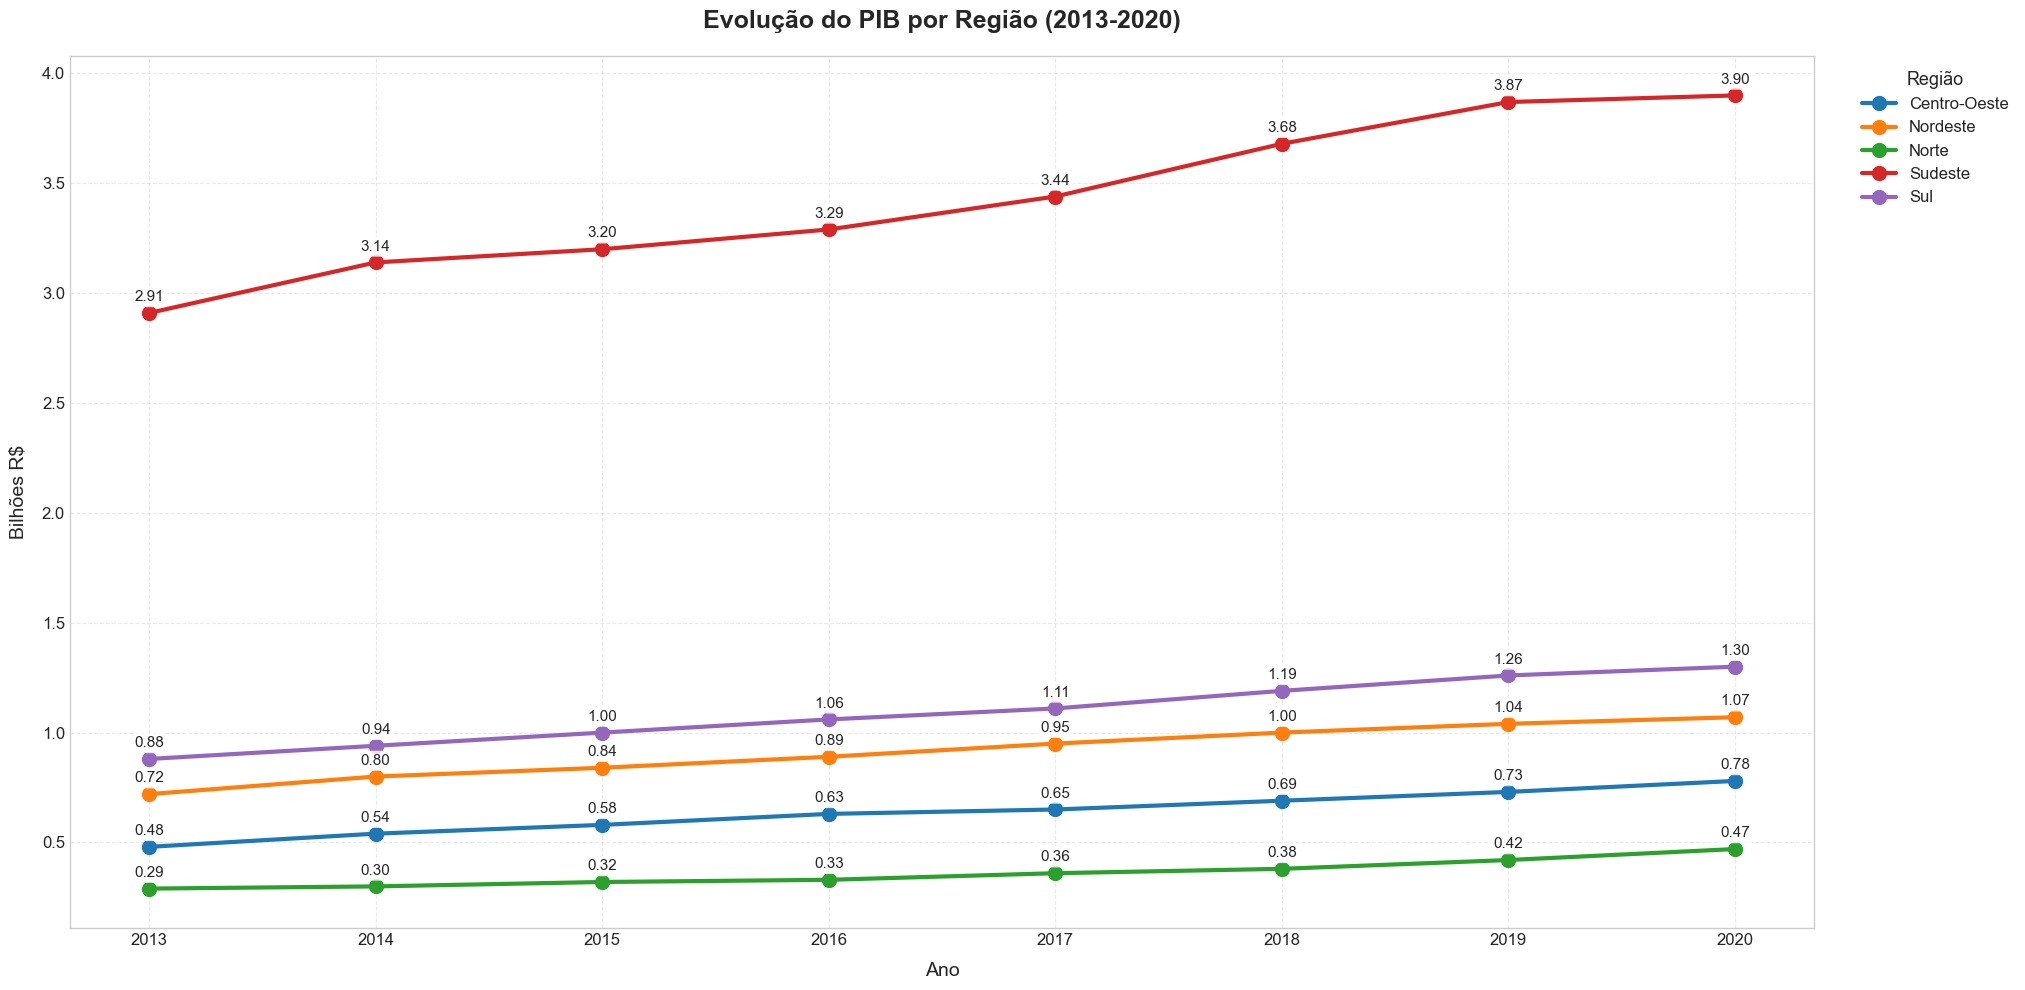

In [155]:
# Configurar figura maior com melhor resolução
plt.figure(figsize=(20, 10), dpi=100)  # Aumente o tamanho e a resolução

# Remover a coluna 'Total' para focar nos anos
dados_grafico = pib_formatado.drop(columns=['Total'])

# Transpor e converter os dados
dados_transpostos = dados_grafico.T
dados_transpostos.index = pd.to_numeric(dados_transpostos.index)

# Plotar com estilo aprimorado
ax = dados_transpostos.plot(kind='line',
                          marker='o',
                          markersize=10,  # Marcadores maiores
                          linewidth=3,    # Linhas mais grossas
                          figsize=(20, 10))

# Formatação profissional
plt.title('Evolução do PIB por Região (2013-2020)', 
         fontsize=18, pad=20, weight='bold')
plt.xlabel('Ano', fontsize=14, labelpad=10)
plt.ylabel('Bilhões R$', fontsize=14, labelpad=10)
plt.grid(alpha=0.4, linestyle='--')

# Ajustar eixos
plt.xticks(dados_transpostos.index, fontsize=12)  # Garantir todos os anos são mostrados
plt.yticks(fontsize=12)

# Legenda destacada
plt.legend(title='Região',
          bbox_to_anchor=(1.12, 1),
          fontsize=12,
          title_fontsize=13,
          framealpha=1)

# Valores nos pontos (ajustados)
for col in dados_transpostos.columns:
    for x, y in zip(dados_transpostos.index, dados_transpostos[col]):
        plt.text(x, y+0.04, f'{y:.2f}',  # +0.1 para evitar sobreposição
                ha='center',
                va='bottom',
                fontsize=11,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))

# Ajustar margens
plt.subplots_adjust(right=0.85)  # Espaço para a legenda
plt.tight_layout()
plt.show()

Observando o gráfico acima possível perceber a discrepância entre os PIBs de outras regiões em relação ao Sudeste, isso ocorre por diversos fatores, entre eles fatores históricos, econômicos, geográficos e estruturais. O Sudeste é composto pelos estados Espírito Santo (ES), Minas Gerais (MG), São Paulo (SP) e Rio de Janeiro (RJ), e é a região com a maior população do Brasil o que estimula a economia, sendo também históricamente o centro da economia brasileira desde o ciclo do café. 

Então é natural que o PIB dessa região seja tão elevado se comparado as demais, apesar do Sul ter uma economia forte, ele possui uma menor escala populacional e industrial, enquanto o Nordeste ainda sofre com infraestrutura limitada e menor industrialização, e o Norte e Centro-Oeste baseiam-se mais em agropecuária e mineração.

Além do que foi citado acima, é perceptível que o PIB ao longos do anos **cresce**, o que contradiz as nossas afimações iniciais de que o PIB sofreu uma grande queda durante a crise de 2014-2016. 

Após uma análise dos motivos por trás dessa contradição, percebemos que o PIB que estamos utilizando nesse projeto (tanto do BrStats quando da tabela do Sidra) é o PIB Nominal, que não é ajustado com base da inflação. Para uma análise real da queda do PIB durante esses anos precisamos do PIB Real, que pode ser obtido utilizando o IPCA (Índice Nacional de Preços ao Consumidor Amplo) fornecido pelo IBGE. 

Para fazermos a conversão do PIB Nominal para o PIB Real, retiramos o IPCA anual do site da [SEAD](https://sead.ac.gov.br/tabela-85-principais-indicadores-inflacionarios-do-brasil/?utm_source=chatgpt.com) (Secretaria de Estado de Administração).

In [144]:
ipca = pd.read_csv('https://raw.githubusercontent.com/anaC-Fernandes/ProjetoDados/refs/heads/main/Datasets/ipca_2013_2020.csv', sep = ',', low_memory= False)

ipca[['Ano']].astype('int')
ipca[['IPCA (%)']].astype('float')

,IPCA (%)
0,5.91
1,6.41
2,10.67
3,6.29
4,2.95
5,3.75
6,4.31
7,4.52


A partir do IPCA podemos fazer uma conversão do PIB Nominal para o PIB Real, seguindo o [Manual de Contas Nacionais do IBGE](https://ftp.ibge.gov.br/Contas_Nacionais/Sistema_de_Contas_Nacionais/Notas_Metodologicas_2010/02_estrutura_scn.pdf) (2010), podemos obter o PIB Real pela deflação do PIB Nominal utilizando um índice de preços apropriado, como o IPCA, dividindo o valor do PIB Nominal pelo índice de preços ajustado para o ano-base, removendo o efeito da inflação. 

Essa prática metodológica também é reforçada na literatura econômica, como em Blanchard (2017), que descreve o uso de índices de preços para converter valores nominais em valores reais, permitindo comparações ao longo do tempo.

Utilizaremos a seguinte fórmula para a conversão: 

$PIB \quad REAL = \frac{PIB \quad NOMINAL}{IPCA}$

In [149]:
# Initialize pib_real as a copy of pib_formatado to preserve the structure
pib_real = pib_formatado.copy()

# Perform the calculation for all years in year_cols
for year in year_cols:
    pib_real[year] = pib_formatado[year] / ipca.loc[ipca['Ano'] == int(year), 'IPCA (%)'].values[0]

Agora que temos o PIB Real de cada ano, podemos visualizar o gráfico correspondente aos valores corrigidos.

<Figure size 2000x1000 with 0 Axes>

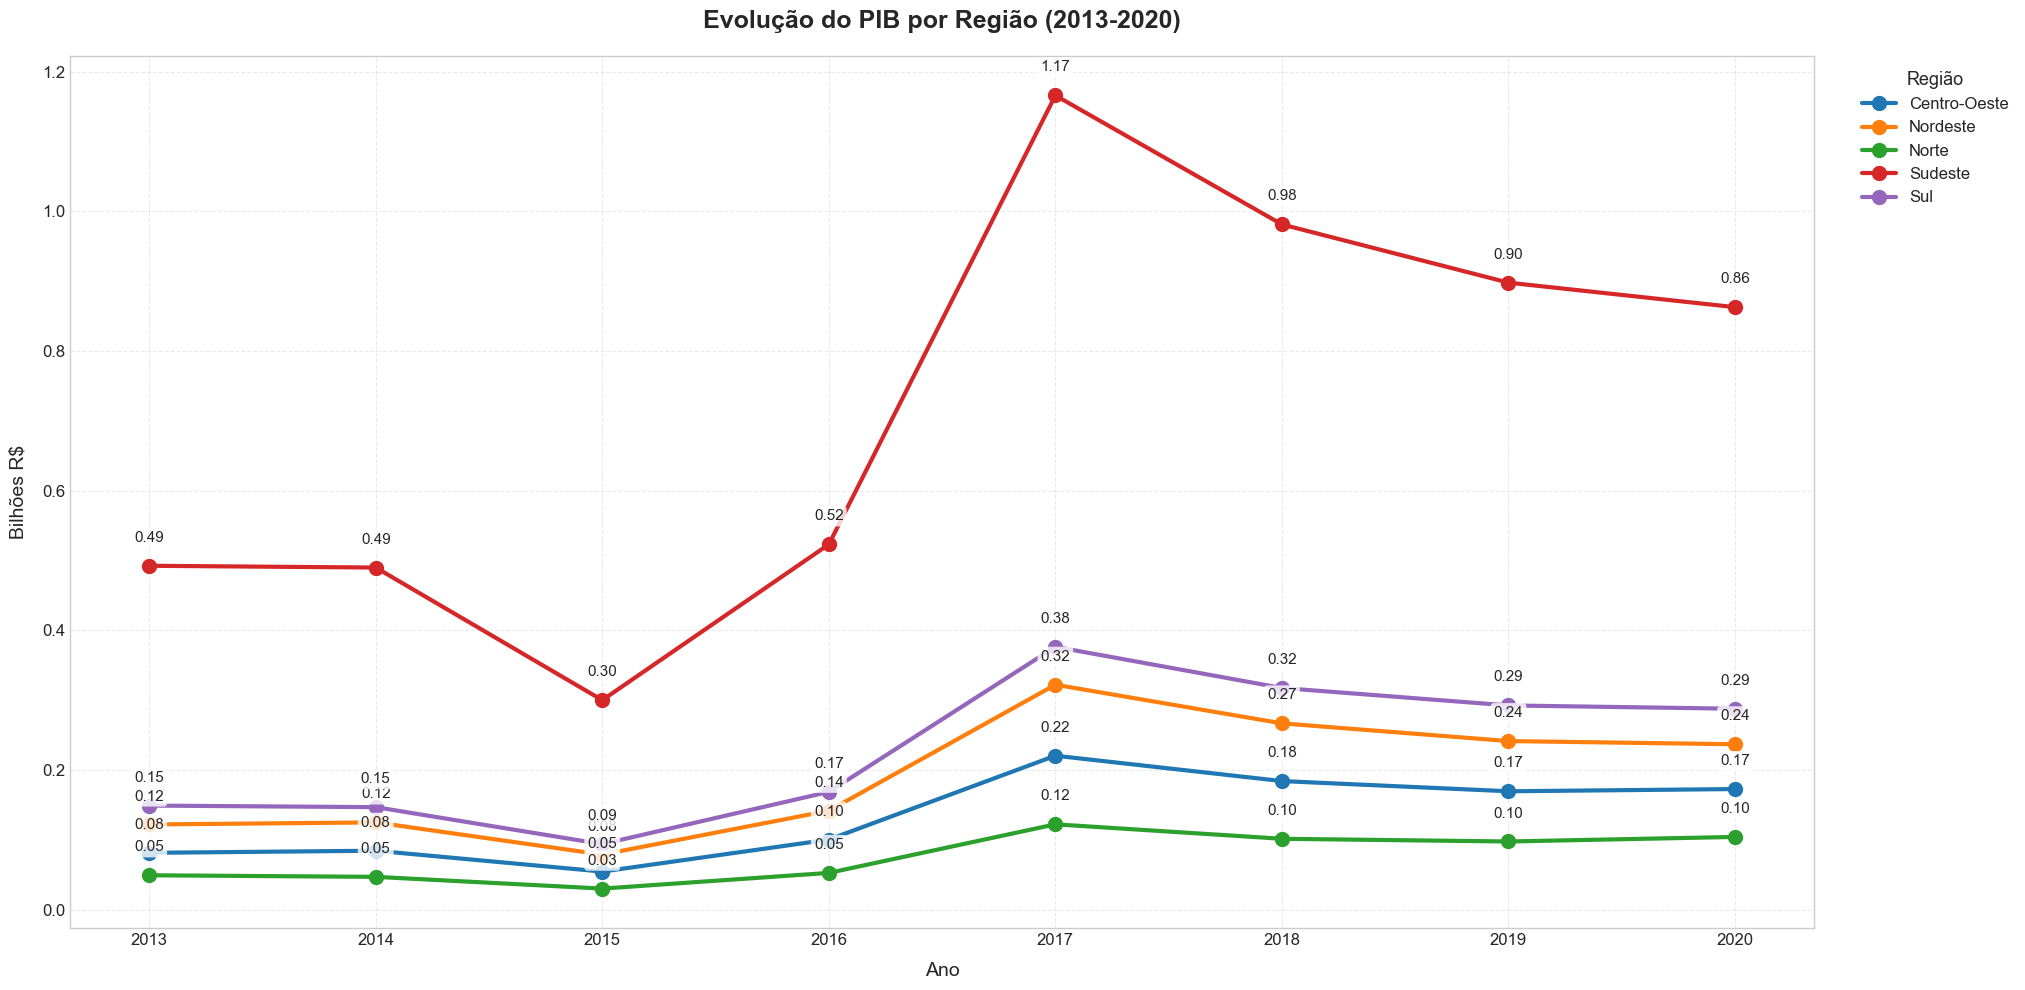

In [ ]:
# Configurar figura maior com melhor resolução
plt.figure(figsize=(20, 10), dpi=100)  # Aumente o tamanho e a resolução

# Remover a coluna 'Total' para focar nos anos
dados_grafico = pib_real.drop(columns=['Total'])

# Transpor e converter os dados
dados_transpostos = dados_grafico.T
dados_transpostos.index = pd.to_numeric(dados_transpostos.index)

# Plotar com estilo aprimorado
ax = dados_transpostos.plot(kind='line',
                          marker='o',
                          markersize=10,  # Marcadores maiores
                          linewidth=3,    # Linhas mais grossas
                          figsize=(20, 10))

# Formatação profissional
plt.title('Evolução do PIB por Região (2013-2020)', 
         fontsize=18, pad=20, weight='bold')
plt.xlabel('Ano', fontsize=14, labelpad=10)
plt.ylabel('Bilhões R$', fontsize=14, labelpad=10)
plt.grid(alpha=0.4, linestyle='--')

# Ajustar eixos
plt.xticks(dados_transpostos.index, fontsize=12)  # Garantir todos os anos são mostrados
plt.yticks(fontsize=12)

# Legenda destacada
plt.legend(title='Região',
          bbox_to_anchor=(1.12, 1),
          fontsize=12,
          title_fontsize=13,
          framealpha=1)

# Valores nos pontos (ajustados)
for col in dados_transpostos.columns:
    for x, y in zip(dados_transpostos.index, dados_transpostos[col]):
        plt.text(x, y+0.04, f'{y:.2f}',  # +0.1 para evitar sobreposição
                ha='center',
                va='bottom',
                fontsize=11,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))

# Ajustar margens
plt.subplots_adjust(right=0.85)  # Espaço para a legenda
plt.tight_layout()
plt.show()

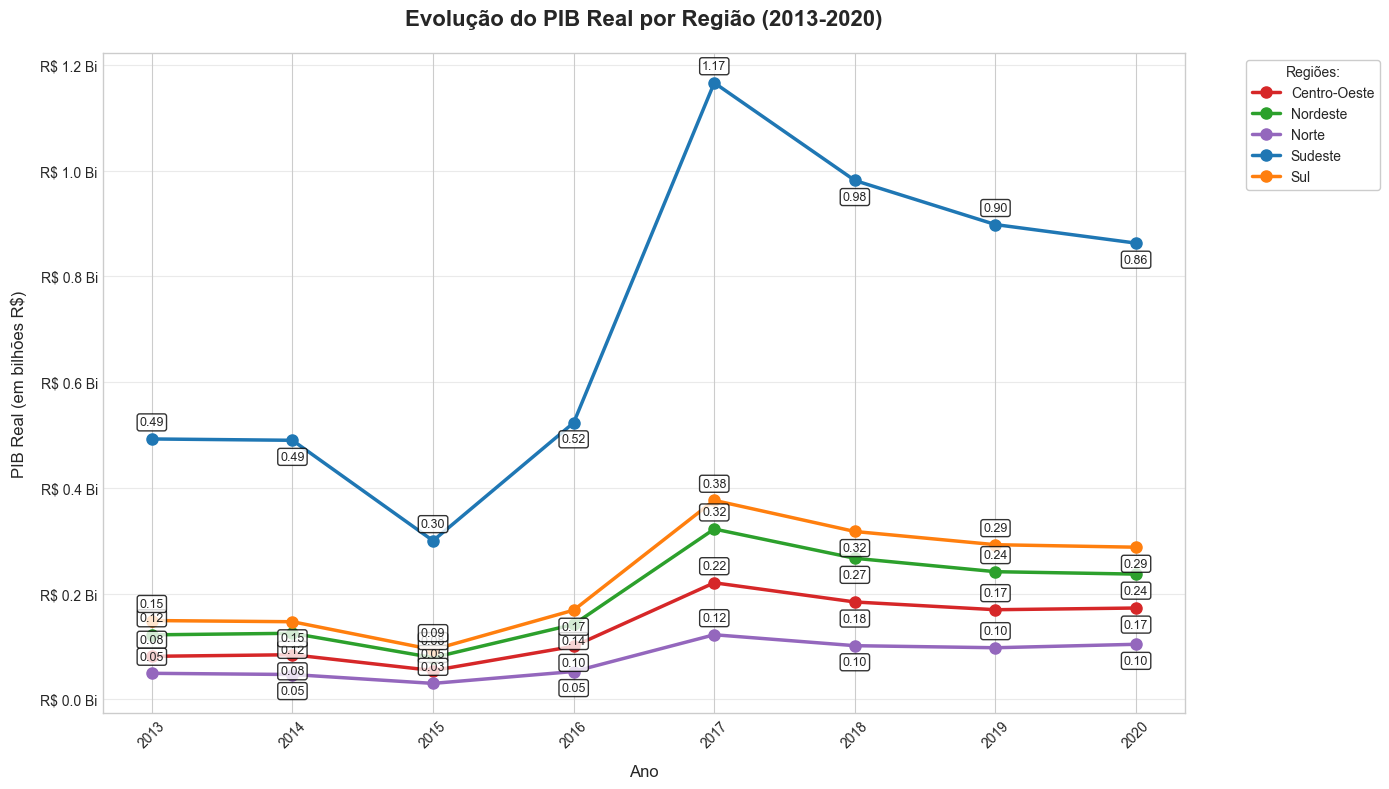

In [159]:
# Configurações de estilo
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))

# Cores para cada região
cores = {
    'Centro-Oeste': '#d62728',
    'Nordeste': '#2ca02c',
    'Norte': '#9467bd',
    'Sudeste': '#1f77b4',
    'Sul': '#ff7f0e'
}

# Extrair anos das colunas (excluindo 'Total')
anos = [str(ano) for ano in range(2013, 2021)]  # 2013 a 2020

# Plotando cada região
for regiao in pib_real.index:
    plt.plot(anos,
             pib_real.loc[regiao, anos],
             marker='o',
             linewidth=2.5,
             markersize=8,
             label=regiao,
             color=cores[regiao])

# Configurações do gráfico
plt.title('Evolução do PIB Real por Região (2013-2020)', 
          fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Ano', fontsize=12, labelpad=10)
plt.ylabel('PIB Real (em bilhões R$)', fontsize=12, labelpad=10)

# Formatando o eixo Y
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'R$ {x:,.1f} Bi'))

# Adicionando valores nos pontos (com offset dinâmico)
for regiao in pib_real.index:
    for i, ano in enumerate(anos):
        valor = pib_real.loc[regiao, ano]
        offset = 0.02 if i % 2 == 0 else -0.02  # Alterna posição
        
        plt.text(ano, valor + offset, 
                 f'{valor:.2f}',
                 ha='center',
                 va='bottom' if i % 2 == 0 else 'top',
                 fontsize=9,
                 bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2'))

# Legenda personalizada
plt.legend(title='Regiões:', 
           bbox_to_anchor=(1.05, 1),
           loc='upper left',
           frameon=True,
           framealpha=1)

# Ajustes finais
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

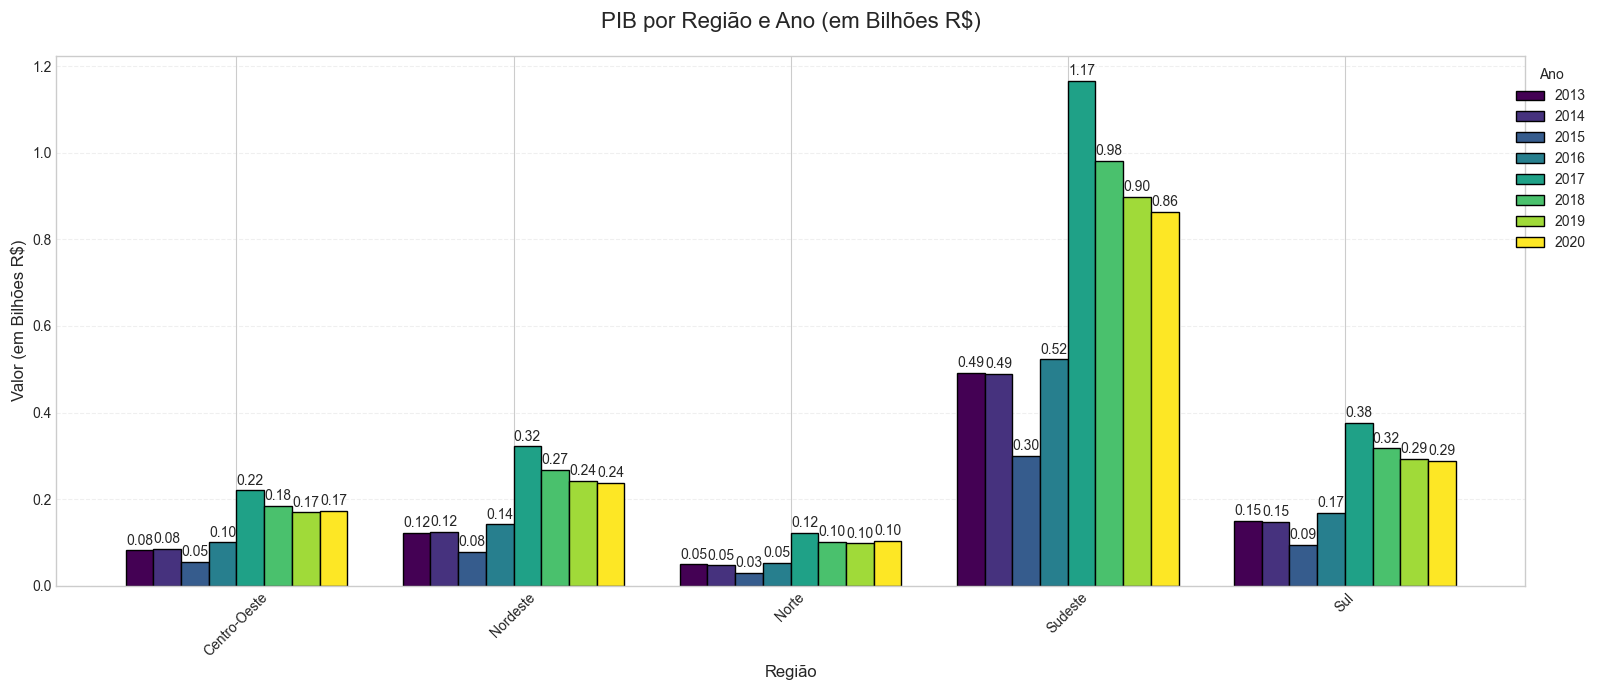

In [151]:
# Remover a coluna 'Total' para focar nos anos
dados_grafico = pib_real.drop(columns=['Total'])

# Criar gráfico de barras agrupadas
ax = dados_grafico.plot(kind='bar',
                        figsize=(16, 7),
                        width=0.8,
                        colormap='viridis',  # Ou use cores personalizadas
                        edgecolor='black')

# Formatação
plt.title('PIB por Região e Ano (em Bilhões R$)', fontsize=16, pad=20)
plt.xlabel('Região', fontsize=12)
plt.ylabel('Valor (em Bilhões R$)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Ano', bbox_to_anchor=(1.05, 1))  # Legenda externa

# Adicionar valores nas barras (opcional)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=2)

plt.tight_layout()
plt.show()